# About Dataset


link  https://www.kaggle.com/datasets/aabdollahii/reddit-data


This dataset contains metadata and text features from Reddit posts collected via the Reddit API (PRAW).

It was created as part of a machine learning project to predict post success — measured by score (upvotes minus downvotes) — based on post content and posting conditions.

Posts were gathered from multiple popular subreddits, including datascience, python, and technology.

Each entry contains both textual features (title, body) and numerical or categorical features (time of post, number of links, comment count, etc.), making it suitable for a range of predictive modelling tasks.

Possible Uses:
Regression: Predict numeric score (post success).
Classification: Predict whether a post will exceed a certain score threshold.
Feature Analysis: Study correlations between posting time/content and engagement.
NLP Experiments: Test text preprocessing, embeddings, sentiment scoring, etc.

## Imports

In [34]:
import os
import kagglehub
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Load The Dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("aabdollahii/reddit-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'reddit-data' dataset.
Path to dataset files: /kaggle/input/reddit-data


In [3]:
print(os.listdir(path))

['reddit_posts.csv']


In [4]:
df = pd.read_csv(f'{path}/reddit_posts.csv')
display(df.head())

,id,subreddit,title,selftext,title_length,text_length,num_links,post_hour,post_day,num_comments,score
0,1mzgkc7,datascience,Weekly Entering & Transitioning - Thread 25 Au...,\n\nWelcome to this week's entering & transit...,13,94,2,4,Monday,15,4
1,1n105of,datascience,Airbnb Data,"Hey everyone,\n\nI work on the data team at [A...",2,298,5,22,Tuesday,23,222
2,1n17500,datascience,"What exactly is ""prompt engineering"" in data s...",I keep seeing people talk about prompt enginee...,8,115,0,4,Wednesday,40,46
3,1n191lg,datascience,NVIDIA AI Released Jet-Nemotron: 53x Faster Hy...,NVIDIA Jet-Nemotron is a new LLM series which ...,10,89,4,5,Wednesday,2,3
4,1n035we,datascience,Is the market really like this? The reality fo...,Hello . I’m a recent Master of Science in Anal...,15,336,0,21,Monday,120,183


## Explore the data sets

In [5]:
df.isnull().sum()   # you can drop or filna lets see

,0
id,0
subreddit,0
title,0
selftext,1225
title_length,0
text_length,0
num_links,0
post_hour,0
post_day,0
num_comments,0


In [6]:
df.shape

(3259, 11)

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
correlation_matrix = df.corr(numeric_only=True)

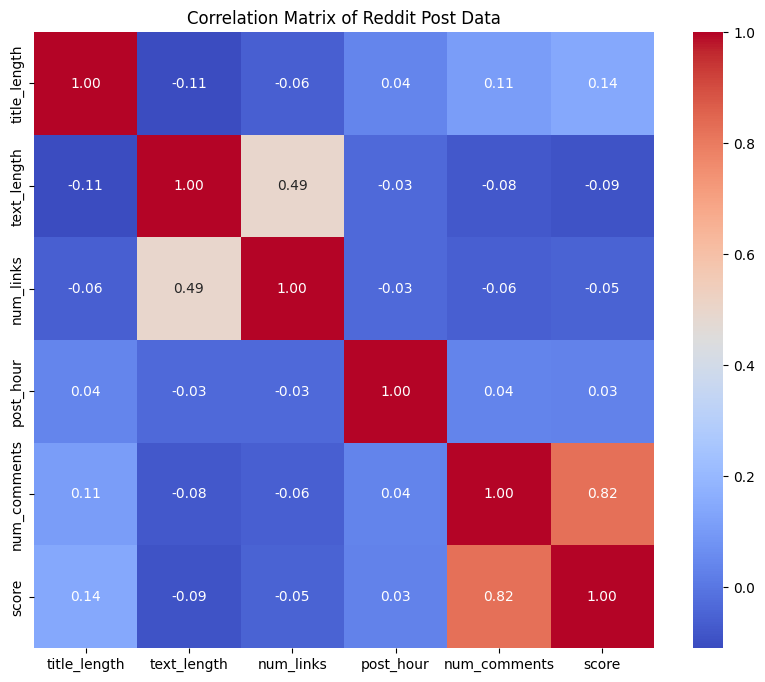

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Reddit Post Data")
plt.show()

## Preprocessing

In [10]:
df = df.drop(columns={"selftext","id"}, axis = 1)

In [11]:
df


,subreddit,title,title_length,text_length,num_links,post_hour,post_day,num_comments,score
0,datascience,Weekly Entering & Transitioning - Thread 25 Au...,13,94,2,4,Monday,15,4
1,datascience,Airbnb Data,2,298,5,22,Tuesday,23,222
2,datascience,"What exactly is ""prompt engineering"" in data s...",8,115,0,4,Wednesday,40,46
3,datascience,NVIDIA AI Released Jet-Nemotron: 53x Faster Hy...,10,89,4,5,Wednesday,2,3
4,datascience,Is the market really like this? The reality fo...,15,336,0,21,Monday,120,183
...,...,...,...,...,...,...,...,...,...
3254,kaggle,How Far Can Kaggle Help You In Your Profession...,10,0,0,10,Thursday,4,5
3255,kaggle,Titanic Prediction using Random forest and R,7,44,1,0,Tuesday,11,5
3256,kaggle,Google Trends Financial Terms—Daily and Weekly...,7,18,2,19,Friday,0,3
3257,kaggle,Research Paper Reading (small) Community,5,124,1,15,Monday,1,5


In [12]:
df["subreddit"].value_counts()

,count
subreddit,
kaggle,990
technology,809
datascience,608
python,495
healthcare,357


In [13]:
df["post_day"].value_counts()

,count
post_day,
Monday,554
Tuesday,551
Wednesday,475
Thursday,459
Friday,440
Saturday,404
Sunday,376


In [14]:
# Map days to numbers (Mon=0,...Sun=6)
day_to_num = {"Monday":0,"Tuesday":1,"Wednesday":2,"Thursday":3,"Friday":4,"Saturday":5,"Sunday":6}
df["day_num"] = df["post_day"].map(day_to_num)

# Cyclic encoding
df["day_sin"] = np.sin(2*np.pi*df["day_num"]/7)
df["day_cos"] = np.cos(2*np.pi*df["day_num"]/7)

df = df.drop("post_day",axis=1)

In [15]:
df

,subreddit,title,title_length,text_length,num_links,post_hour,num_comments,score,day_num,day_sin,day_cos
0,datascience,Weekly Entering & Transitioning - Thread 25 Au...,13,94,2,4,15,4,0,0.000000,1.000000
1,datascience,Airbnb Data,2,298,5,22,23,222,1,0.781831,0.623490
2,datascience,"What exactly is ""prompt engineering"" in data s...",8,115,0,4,40,46,2,0.974928,-0.222521
3,datascience,NVIDIA AI Released Jet-Nemotron: 53x Faster Hy...,10,89,4,5,2,3,2,0.974928,-0.222521
4,datascience,Is the market really like this? The reality fo...,15,336,0,21,120,183,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
3254,kaggle,How Far Can Kaggle Help You In Your Profession...,10,0,0,10,4,5,3,0.433884,-0.900969
3255,kaggle,Titanic Prediction using Random forest and R,7,44,1,0,11,5,1,0.781831,0.623490
3256,kaggle,Google Trends Financial Terms—Daily and Weekly...,7,18,2,19,0,3,4,-0.433884,-0.900969
3257,kaggle,Research Paper Reading (small) Community,5,124,1,15,1,5,0,0.000000,1.000000


In [16]:
onehot_cols = ["subreddit"]
df = pd.get_dummies(df, columns=onehot_cols)

display(df.head())

,title,title_length,text_length,num_links,post_hour,num_comments,score,day_num,day_sin,day_cos,subreddit_datascience,subreddit_healthcare,subreddit_kaggle,subreddit_python,subreddit_technology
0,Weekly Entering & Transitioning - Thread 25 Au...,13,94,2,4,15,4,0,0.000000,1.000000,True,False,False,False,False
1,Airbnb Data,2,298,5,22,23,222,1,0.781831,0.623490,True,False,False,False,False
2,"What exactly is ""prompt engineering"" in data s...",8,115,0,4,40,46,2,0.974928,-0.222521,True,False,False,False,False
3,NVIDIA AI Released Jet-Nemotron: 53x Faster Hy...,10,89,4,5,2,3,2,0.974928,-0.222521,True,False,False,False,False
4,Is the market really like this? The reality fo...,15,336,0,21,120,183,0,0.000000,1.000000,True,False,False,False,False


In [17]:
df

,title,title_length,text_length,num_links,post_hour,num_comments,score,day_num,day_sin,day_cos,subreddit_datascience,subreddit_healthcare,subreddit_kaggle,subreddit_python,subreddit_technology
0,Weekly Entering & Transitioning - Thread 25 Au...,13,94,2,4,15,4,0,0.000000,1.000000,True,False,False,False,False
1,Airbnb Data,2,298,5,22,23,222,1,0.781831,0.623490,True,False,False,False,False
2,"What exactly is ""prompt engineering"" in data s...",8,115,0,4,40,46,2,0.974928,-0.222521,True,False,False,False,False
3,NVIDIA AI Released Jet-Nemotron: 53x Faster Hy...,10,89,4,5,2,3,2,0.974928,-0.222521,True,False,False,False,False
4,Is the market really like this? The reality fo...,15,336,0,21,120,183,0,0.000000,1.000000,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,How Far Can Kaggle Help You In Your Profession...,10,0,0,10,4,5,3,0.433884,-0.900969,False,False,True,False,False
3255,Titanic Prediction using Random forest and R,7,44,1,0,11,5,1,0.781831,0.623490,False,False,True,False,False
3256,Google Trends Financial Terms—Daily and Weekly...,7,18,2,19,0,3,4,-0.433884,-0.900969,False,False,True,False,False
3257,Research Paper Reading (small) Community,5,124,1,15,1,5,0,0.000000,1.000000,False,False,True,False,False


In [18]:
# Convert the boolean columns created by get_dummies to integers
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [19]:
df.head()

,title,title_length,text_length,num_links,post_hour,num_comments,score,day_num,day_sin,day_cos,subreddit_datascience,subreddit_healthcare,subreddit_kaggle,subreddit_python,subreddit_technology
0,Weekly Entering & Transitioning - Thread 25 Au...,13,94,2,4,15,4,0,0.000000,1.000000,1,0,0,0,0
1,Airbnb Data,2,298,5,22,23,222,1,0.781831,0.623490,1,0,0,0,0
2,"What exactly is ""prompt engineering"" in data s...",8,115,0,4,40,46,2,0.974928,-0.222521,1,0,0,0,0
3,NVIDIA AI Released Jet-Nemotron: 53x Faster Hy...,10,89,4,5,2,3,2,0.974928,-0.222521,1,0,0,0,0
4,Is the market really like this? The reality fo...,15,336,0,21,120,183,0,0.000000,1.000000,1,0,0,0,0


In [20]:
df["title"][2]

'What exactly is "prompt engineering" in data science?'

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Parameters
max_features_title = 500   # limit vocabulary size for titles
max_features_selftext = 2000  # limit vocabulary size for selftexts
ngram_range = (1, 2)  # capture unigrams + bigrams

# TF-IDF for titles
tfidf_title = TfidfVectorizer(max_features=max_features_title, ngram_range=ngram_range)
title_tfidf_matrix = tfidf_title.fit_transform(df['title'].fillna(''))


#  Combine into single DataFrame
title_df = pd.DataFrame(title_tfidf_matrix.toarray(), columns=[f"title_tfidf_{f}" for f in tfidf_title.get_feature_names_out()])

tfidf_df = pd.concat([title_df], axis=1)
print(f"TF-IDF Features Shape: {tfidf_df.shape}")


TF-IDF Features Shape: (3259, 500)


In [23]:
tfidf_df

,title_tfidf_000,title_tfidf_000 in,title_tfidf_10,title_tfidf_100,title_tfidf_11,title_tfidf_2025,title_tfidf_30,title_tfidf_50,title_tfidf_about,title_tfidf_access,...,title_tfidf_working on,title_tfidf_world,title_tfidf_worth,title_tfidf_would,title_tfidf_would you,title_tfidf_year,title_tfidf_years,title_tfidf_you,title_tfidf_your,title_tfidf_youtube
0,0.0,0.0,0.0,0.0,0.0,0.559721,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321514,0.369428,0.0
3255,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3256,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3257,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [26]:
df = pd.concat([df, tfidf_df], axis=1)

In [28]:
df = df.drop("title",axis=1)

In [29]:
df

,title_length,text_length,num_links,post_hour,num_comments,score,day_num,day_sin,day_cos,subreddit_datascience,...,title_tfidf_working on,title_tfidf_world,title_tfidf_worth,title_tfidf_would,title_tfidf_would you,title_tfidf_year,title_tfidf_years,title_tfidf_you,title_tfidf_your,title_tfidf_youtube
0,13,94,2,4,15,4,0,0.000000,1.000000,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,2,298,5,22,23,222,1,0.781831,0.623490,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,8,115,0,4,40,46,2,0.974928,-0.222521,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,10,89,4,5,2,3,2,0.974928,-0.222521,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,15,336,0,21,120,183,0,0.000000,1.000000,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,10,0,0,10,4,5,3,0.433884,-0.900969,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321514,0.369428,0.0
3255,7,44,1,0,11,5,1,0.781831,0.623490,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3256,7,18,2,19,0,3,4,-0.433884,-0.900969,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3257,5,124,1,15,1,5,0,0.000000,1.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [30]:
df.shape

(3259, 514)

## Building the model

In [31]:
numeric_cols = [
    "title_length","text_length","num_links","post_hour",
    "num_comments","day_num","day_sin","day_cos"
]

In [33]:
pre = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),        # scale dense
    ("rest", "passthrough", [c for c in df.columns if c not in numeric_cols + ["score"]])
], sparse_threshold=0.3)


In [38]:
y = df["score"]
X = df.drop(columns=["score"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ("pre", pre),
    ("ridge", Ridge(alpha=2.0, random_state=42))
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)


## Results

In [39]:
print("RMSE:", mean_squared_error(y_test, pred)**0.5)
print("R²:", r2_score(y_test, pred))

RMSE: 1166.0094153426182
R²: 0.7241288849673112


In [40]:
from sklearn.linear_model import RidgeCV
alphas = [0.1, 0.5, 1, 2, 5, 10, 50, 100]
model = RidgeCV(alphas=alphas, scoring="r2", cv=5)
model.fit(X_train, y_train)
print("Best alpha:", model.alpha_)
print("CV R²:", model.best_score_)

Best alpha: 50.0
CV R²: 0.5458412624813261


## What we can do better

In [46]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb

X = df.drop(columns=["score"])
y = df["score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric="rmse",
         callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])

pred = lgbm.predict(X_test)
print("RMSE:", mean_squared_error(y_test, pred)**0.5)
print("R²:", r2_score(y_test, pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4639
[LightGBM] [Info] Number of data points in the train set: 2607, number of used features: 194
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 426.433065
RMSE: 1460.379585250922
R²: 0.5672534420274212


In [57]:
!pip install xgboost


In [60]:
# wrap data in DMatrix (XGBoost's own format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

# training params
params = {
    "objective": "reg:squarederror",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "eval_metric": "rmse"
}

# train with early stopping
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=False
)

# predict
pred = bst.predict(dvalid)
print("RMSE:", mean_squared_error(y_test, pred)**0.5)
print("R²:", r2_score(y_test, pred))

RMSE: 1349.038314874711
R²: 0.630724310874939


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

y = df["score"]
X = df.drop(columns=["score"])

numeric_cols = [c for c in ["title_length","text_length","num_links","post_hour",
                            "num_comments","day_num","day_sin","day_cos"] if c in X.columns]

pre = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("rest", "passthrough", [c for c in X.columns if c not in numeric_cols])
], sparse_threshold=0.3)

alphas = [0.1, 0.3, 0.5, 1, 2, 5, 10, 20, 50, 100, 200]

model = Pipeline([
    ("pre", pre),
    ("ridge", RidgeCV(alphas=alphas, scoring="r2", cv=5))
])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_tr, y_tr)
pred = model.predict(X_te)

## Best results

In [72]:
print("Best alpha:", model.named_steps["ridge"].alpha_)
print("RMSE:", mean_squared_error(y_te, pred)**0.5)
print("R²:", r2_score(y_te, pred))

Best alpha: 200.0
RMSE: 1132.6074318158987
R²: 0.7397079345163537
